<h1 align="center" style="font-variant: small-caps">How to build a genome-scale cell growth model</h1>
<h2 align="center">TUTORIAL 2 &mdash; Check and correct the consistency of the model</h2>
<h5 align="center">(<code>Version 14</code>, June 2025)</h5>

<div align="center" style="max-width:250px;display:block;margin:auto;">

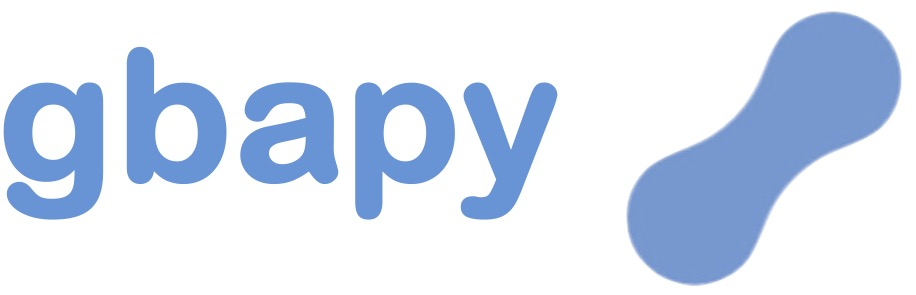

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Objective](#objective)
- [2. Load the CGM builder](#load)
- [3. Check for unproduced metabolites](#unproduced)
- [4. Check for infeasible loops](#loops)
- [5. Check for isolated metabolites](#isolated)
- [6. Final model check and backup](#check)

# In summary

<div align="center" style="max-width:600px;display:block;margin:auto;">

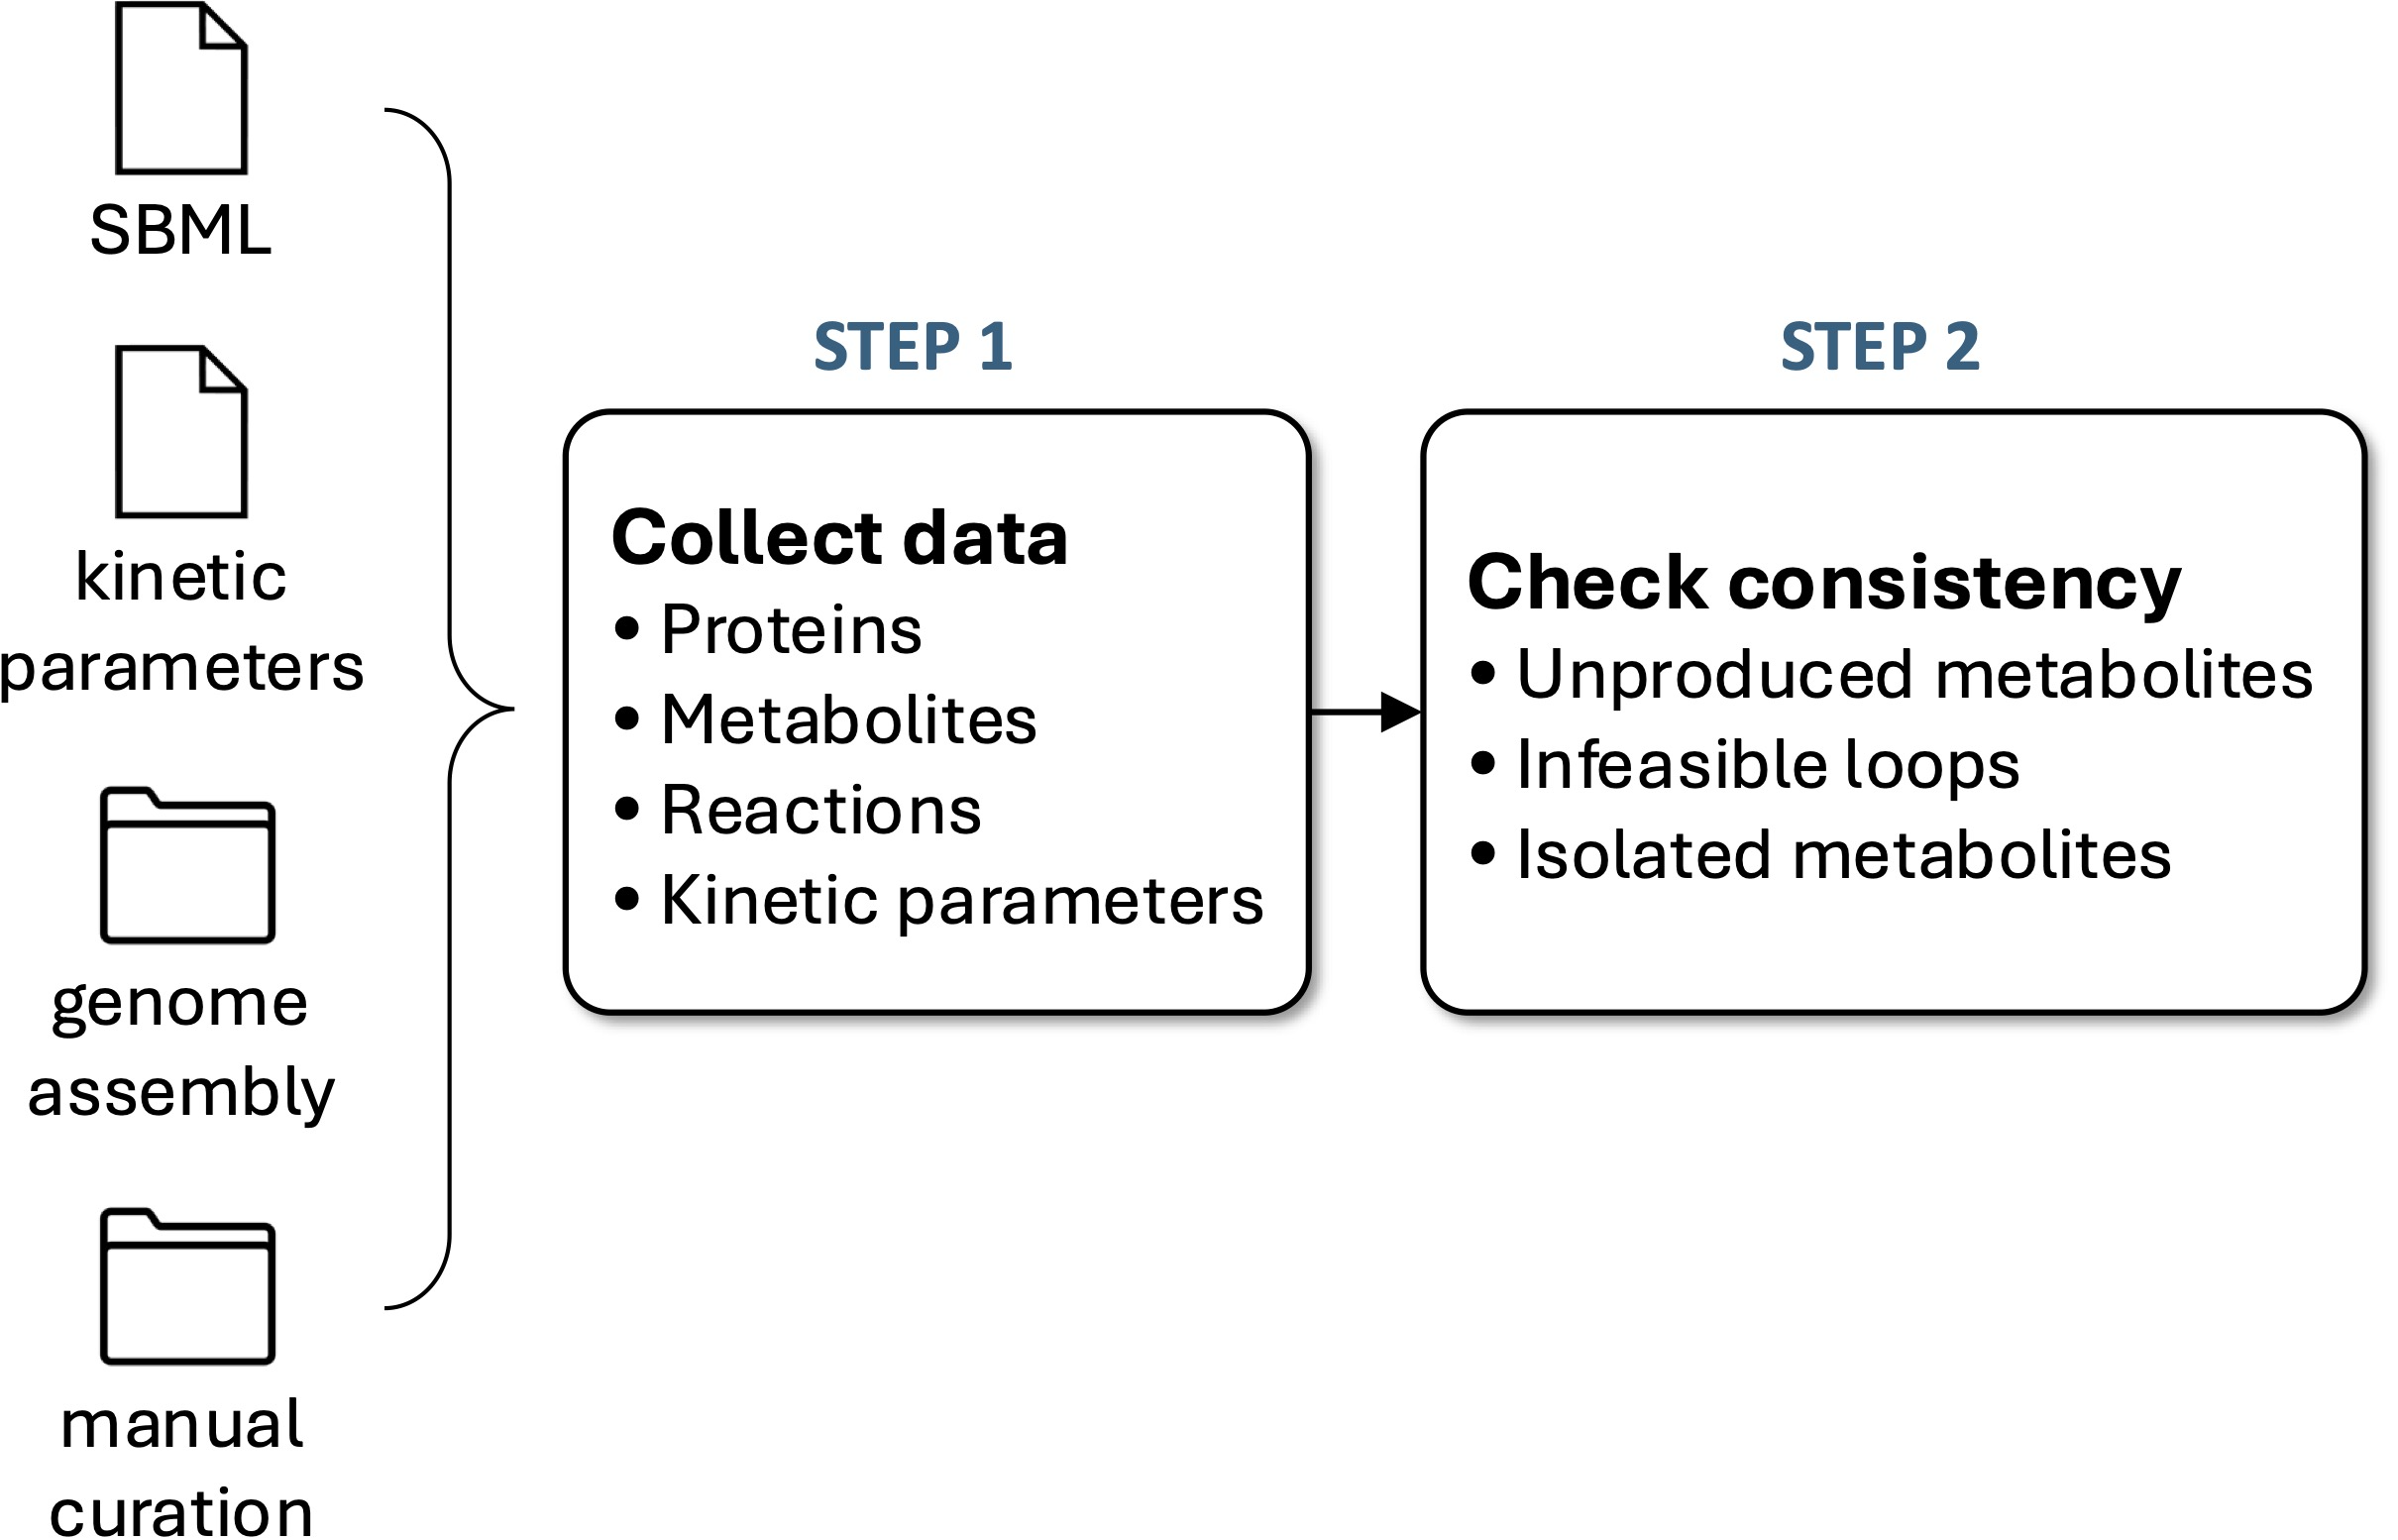

</div>

<div align="center">
<br/><br/>
<strong>&rarr; At each step of this tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Objective <a id="objective"></a>

[&#10148; Back to the table of contents](#table_of_contents)

Four types of structural inconsistencies must be detected prior to CGM building:

$\bullet$ <strong>Connectivity issues:</strong><br/>Reactions without product or any stoichiometry, metabolites not connected to any reaction, etc. These basic connectivity errors must be checked after each modification of the model with dedicated <strong>GBApy</strong> methods.

$\bullet$ <strong>Unproduced metabolites:</strong><br/>Some internal metabolites could be unproduced, <em>i.e.</em> not being the product of any reaction, and break mass conservation. In this case, two corrective actions exist: <strong>(i)</strong> Delete the metabolite with the risk of breaking mass conservation, <strong>(ii)</strong> Create a transporter or a new reaction to produce this metabolite.

$\bullet$ <strong>Infeasible loops:</strong><br/>These loops appear when two metabolites are the product of each other, but are never produced by a tierce reaction, making the loop infeasible as no matter enters the loop.

$\bullet$ <strong>Isolated metabolites:</strong><br/>Metabolites being solely imported and not involved in any metabolic reaction. This is often the case when metabolites are only involved in the FBA biomass function.

<strong>GBApy</strong> provides automated methods to detect each of these inconsistencies.

In [1]:
import gba
import cobra

# 2. Load the CGM builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.load_builder( path )</code> | Load a CGM builder from a backup |

</div>

The CGM builder is loaded from the backup created in step 1.
We also re-load the original SBML model of a minimal cell.

In [2]:
builder    = gba.load_builder("backup/mmsyn_build_1.cgmbuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpycl914gk.lp
Reading time = 0.00 seconds
: 303 rows, 674 columns, 3056 nonzeros


# 3. Check for unproduced metabolites <a id="unproduced"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.detect_unproduced_metabolites( verbose )</code> | Detect and display unproduced metabolites |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.check_model()</code> | Check connectivity issues in the model |

</div>

In [3]:
unproduced = builder.detect_unproduced_metabolites(verbose=True)

⚠ Warning,Metabolite ahcys_c is not produced by any reaction.


The metabolite `ahcys_c` is not produced nor imported in the cytoplasm.

This metabolite is part of the amino-acid metabolism (see [Breuer et al. 2019](https://elifesciences.org/articles/36842)) and is expected to be a product of DNA/RNA modification. However this reaction is not implemented in the model.

<div align="center" style="max-width:600px;display:block;margin:auto;">

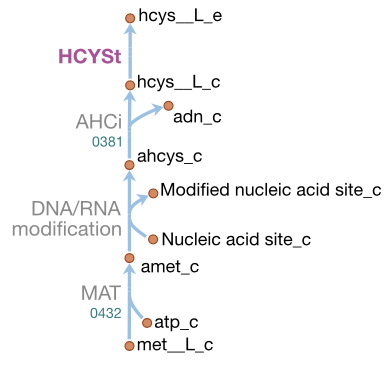

</div>

The whole pathway (reactions `MAT`, `AHCi` and `HCYSt`) can be safely removed, as well as metabolites `amet_c`, `ahcys_c`, `hcys__L_c` and `hcys__L_e`, as they are not involved in any other reaction.

In [4]:
reactions   = ["MAT", "HCYSt", "AHCi"]
metabolites = ["amet_c", "hcys__L_e", "hcys__L_c", "ahcys_c"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

In [5]:
unproduced = builder.detect_unproduced_metabolites(verbose=True)

❯ Info,No unproduced metabolites in the model.


No other unproduced metabolite is detected. We also check the model for the introduction of small errors.

In [6]:
builder.check_model()

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


# 4. Check for infeasible loops <a id="loops"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.detect_infeasible_loops( verbose )</code> | Detect and display infeasible loops |
| <code>gba.Reaction(id, name, reaction_type, lb, ub, metabolites, proteins, GPR, enzyme_mass )</code> | Constructor of the class <code>gba.Reaction</code> |
| <code>gba.Reaction.has_missing_kcat_value( )</code> | Indicate if $k_\text{cat}$ values are missing in the reaction |
| <code>gba.Reaction.complete_kcat_values( value )</code> | Fill missing $k_\text{cat}$ values with a given value |
| <code>gba.Reaction.has_missing_km_value( )</code> | Indicate if $K_\text{M}$ values are missing in the reaction |
| <code>gba.Reaction.complete_km_values( value )</code> | Fill missing $K_\text{M}$ values with a given value |
| <code>gba.Builder.add_metabolite( metabolite )</code> | Add a metabolite to the CGM builder |
| <code>gba.Builder.add_reaction( reaction )</code> | Add a reaction to the CGM builder |

</div>

We will now check if infeasible loops exist, and correct them.

In [7]:
infeasible_loops = builder.detect_infeasible_loops(verbose=True)

⚠ Warning,Infeasible loop between alatrna_c and trnaala_c.


⚠ Warning,Infeasible loop between argtrna_c and trnaarg_c.


⚠ Warning,Infeasible loop between asntrna_c and trnaasn_c.


⚠ Warning,Infeasible loop between asptrna_c and trnaasp_c.


⚠ Warning,Infeasible loop between cystrna_c and trnacys_c.


⚠ Warning,Infeasible loop between glutrna_c and trnaglu_c.


⚠ Warning,Infeasible loop between glytrna_c and trnagly_c.


⚠ Warning,Infeasible loop between histrna_c and trnahis_c.


⚠ Warning,Infeasible loop between iletrna_c and trnaile_c.


⚠ Warning,Infeasible loop between leutrna_c and trnaleu_c.


⚠ Warning,Infeasible loop between lystrna_c and trnalys_c.


⚠ Warning,Infeasible loop between phetrna_c and trnaphe_c.


⚠ Warning,Infeasible loop between protrna_c and trnapro_c.


⚠ Warning,Infeasible loop between sertrna_c and trnaser_c.


⚠ Warning,Infeasible loop between thrtrna_c and trnathr_c.


⚠ Warning,Infeasible loop between trdox_c and trdrd_c.


⚠ Warning,Infeasible loop between trnatrp_c and trptrna_c.


⚠ Warning,Infeasible loop between trnatyr_c and tyrtrna_c.


⚠ Warning,Infeasible loop between trnaval_c and valtrna_c.


18 charged/uncharged tRNAs are involved in infeasible loops. This is also the case of thioredoxin (`trdox_c` and `trdrd_c`).
In addition, our procedure does not detect two other unproduced tRNAs: `trnagln_c` and `trnamet_c` which are involved in specific pathways.

<div align="center" style="max-width:600px;display:block;margin:auto;">

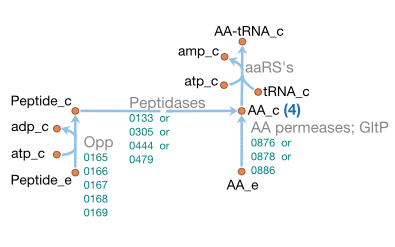

</div>

To solve this problem, we will create a production reaction per uncharged tRNA. For each uncharged tRNA, we will use the nucleotide count of its sequence to set up the stoichiometry of the reaction. Following <a href="https://elifesciences.org/articles/36842">Breuer et al. (2019)</a>, we assume a cost of <strong>0.41 ATP/nucleotide</strong> in RNA synthesis.

We will also add spontaneous transporters for thioredoxin metabolites.

In [8]:
# Create a production reaction for each uncharged tRNA
for m in builder.metabolites.values():
    if m.species_type == gba.SpeciesType.RNA and m.id.startswith("trna"):
        r_id     = m.id[:-2]+"P"
        r_name   = m.name+" production"
        n_atp    = m.formula.count("A")
        n_ctp    = m.formula.count("C")
        n_gtp    = m.formula.count("G")
        n_utp    = m.formula.count("U")
        n_ppi    = n_atp+n_ctp+n_gtp+n_utp
        atp_cost = int(n_ppi*0.41)
        stoichiometry = {
            "atp_c": -n_atp-atp_cost,
            "ctp_c": -n_ctp,
            "gtp_c": -n_gtp,
            "utp_c": -n_utp,
            "h2o_c": -atp_cost,
            m.id: 1,
            "adp_c": atp_cost,
            "h_c": atp_cost,
            "pi_c": atp_cost,
            "ppi_c": n_ppi
        }
        reaction = gba.Reaction(id=r_id, name=r_name,
                                reaction_type=gba.ReactionType.Metabolic,
                                lb=0.0, ub=1000.0,
                                metabolites=stoichiometry,
                                proteins={"average_protein": 1.0},
                                GPR=builder.reactions["RNAP"].GPR)
        reaction.enforce_kcat_irreversibility()
        reaction.complete_kcat_values(45000.0)
        reaction.enforce_km_irreversibility()
        reaction.complete_km_values(0.00013)
        builder.add_reaction(reaction)

# Create new external metabolites for thioredoxin
metabolite = gba.Metabolite(id="trdox_e", name="Oxydized thioredoxin",
                            species_location=gba.SpeciesLocation.External,
                            species_type=gba.SpeciesType.MacroMolecule,
                            formula="R", mass=builder.metabolites["trdox_c"].mass,
                            annotation=builder.metabolites["trdox_c"].annotation)
builder.add_metabolite(metabolite)
metabolite = gba.Metabolite(id="trdrd_e", name="Reduced thioredoxin",
                            species_location=gba.SpeciesLocation.External,
                            species_type=gba.SpeciesType.MacroMolecule,
                            formula="R", mass=builder.metabolites["trdrd_c"].mass,
                            annotation=builder.metabolites["trdrd_c"].annotation)
builder.add_metabolite(metabolite)

# Create spontaneous transporters for thioredoxin
reaction = gba.Reaction(id="trdoxt", name="Oxydized thioredoxin transport via channel",
                        reaction_type=gba.ReactionType.Transport,
                        lb=-1000.0, ub=1000.0,
                        metabolites={"trdox_e": -1, "trdox_c": 1},
                        proteins={"spontaneous_protein": 1.0},
                        GPR=gba.ReactionGPR.NONE)
reaction.enforce_kcat_irreversibility()
reaction.complete_kcat_values(1e+10)
reaction.enforce_km_irreversibility()
reaction.complete_km_values(1e-10)
builder.add_reaction(reaction)
reaction = gba.Reaction(id="trdrdt", name="Reduced thioredoxin transport via channel",
                        reaction_type=gba.ReactionType.Transport,
                        lb=-1000.0, ub=1000.0,
                        metabolites={"trdrd_e": -1, "trdrd_c": 1},
                        proteins={"spontaneous_protein": 1.0},
                        GPR=gba.ReactionGPR.NONE)
reaction.enforce_kcat_irreversibility()
reaction.complete_kcat_values(1e+10)
reaction.enforce_km_irreversibility()
reaction.complete_km_values(1e-10)
builder.add_reaction(reaction)

In [9]:
infeasible_loops = builder.detect_infeasible_loops(verbose=True)

❯ Info,No infeasible loops in the model.


# 5. Check for isolated metabolites <a id="isolated"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.detect_isolated_metabolites( verbose )</code> | Detect and display isolated metabolites |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |

</div>

We will now check if isolated metabolites are present, <em>i.e.</em>, imported but not involved in any other reaction.

In [10]:
isolated = builder.detect_isolated_metabolites(verbose=True)

⚠ Warning,Metabolite ca2_c is isolated (imported only).


⚠ Warning,Metabolite chsterol_c is isolated (imported only).


⚠ Warning,Metabolite cl_c is isolated (imported only).


⚠ Warning,Metabolite cytd_c is isolated (imported only).


⚠ Warning,Metabolite k_c is isolated (imported only).


⚠ Warning,Metabolite mg2_c is isolated (imported only).


⚠ Warning,Metabolite pydx5p_c is isolated (imported only).


⚠ Warning,Metabolite sprm_c is isolated (imported only).


⚠ Warning,Metabolite tag_c is isolated (imported only).


⚠ Warning,Metabolite thmpp_c is isolated (imported only).


⚠ Warning,Metabolite uri_c is isolated (imported only).


We found 11 metabolites. We will remove them and their associated transporter:

In [11]:
reactions = []
for m_id in isolated:
    external_id = m_id[:-2]+"_e"
    r_id        = builder.which_reaction(m_id)
    assert len(r_id) == 1
    builder.remove_reaction(r_id[0])
    builder.remove_metabolite(m_id)
    builder.remove_metabolite(external_id)

In [12]:
isolated = builder.detect_isolated_metabolites(verbose=True)

❯ Info,No isolated metabolites in the model.


# 6. Final model check and backup <a id="check"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.check_model()</code> | Check connectivity issues in the model |
| <code>gba.Builder.summary()</code> | Display a summary of a CGM builder |
| <code>gba.Builder.build_FBA_model()</code> | Reconstruct a FBA model from scratch |
| <code>gba.backup_builder( builder, name, path )</code> | Backup a CGM builder |

</div>

Finally, we run a final check of the model, and we back it up.

In [13]:
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


In [14]:
builder.summary()

CGM build JCVI-syn3A summary General 
 
 
 Category 
 Count 
 
 
 
 
 Known proteins 
 461 
 
 
 Modeled proteins 
 134 
 
 
 Metabolites 
 279 
 
 
 Reactions 
 260 
 
 
 Metabolites 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Small molecules 
 217 
 77.78% 
 
 
 Macro-molecules 
 20 
 7.17% 
 
 
 DNA(s) 
 1 
 0.36% 
 
 
 RNA(s) 
 41 
 14.70% 
 
 
 Proteins 
 0 
 0.00% 
 
 
 Unknown 
 0 
 0.00% 
 
 
 Reaction types 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Metabolic 
 184 
 70.77% 
 
 
 Transport 
 76 
 29.23% 
 
 
 Exchange 
 0 
 0.00% 
 
 
 Reaction directions 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Forward 
 200 
 76.92% 
 
 
 Backward 
 1 
 0.38% 
 
 
 Reversible 
 59 
 22.69%

Compared to the previous version of the model, we now have 279 metabolites (24 less), and 260 reactions (8 more). The modification has also slightly modified the growth rate (0.3480) compared to the original model (0.3424).

In [15]:
builder.build_FBA_model()
fba_sol = sbml_model.optimize()
print("> Reconstructed growth rate:", round(builder.FBA_solution.objective_value, 5), "\n> Original growth rate:     ", round(fba_sol.objective_value, 5))

> Reconstructed growth rate: 0.34799 
> Original growth rate:      0.34239


In [16]:
gba.backup_builder(builder, "mmsyn_build_2", "backup")